In [1]:
import numpy as np # array manipulation & linear algebra
import pandas as pd # read , write and processing of data
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

%config InlineBackend.figure_format = 'retina'

# Data Reading

In [2]:
df = pd.read_csv('C:/Users/Pramod/Downloads/seoul-bike-sharing-prediction-main/Untitled Folder/SeoulBikeData.csv', encoding='unicode_escape')

In [3]:
df.sample(2) # any two sample records from data # from sample rows we can see date format is dd/mm/yyyy. 

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
6819,11/09/2018,261,3,18.2,52,1.5,2000,8.1,0.0,0.0,0.0,Autumn,No Holiday,Yes
5163,04/07/2018,372,3,24.9,83,0.2,1857,21.8,0.0,0.0,0.0,Summer,No Holiday,Yes


In [4]:
df.dtypes # Date has data type object hence need to convert it as date & No need to change data type of other features

Date                          object
Rented Bike Count              int64
Hour                           int64
Temperature(°C)              float64
Humidity(%)                    int64
Wind speed (m/s)             float64
Visibility (10m)               int64
Dew point temperature(°C)    float64
Solar Radiation (MJ/m2)      float64
Rainfall(mm)                 float64
Snowfall (cm)                float64
Seasons                       object
Holiday                       object
Functioning Day               object
dtype: object

In [5]:
# df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x,'%d/%m/%Y'))  # alternative to pandas to_datetime function
df['Date'] = pd.to_datetime(df['Date'] , format = '%d/%m/%Y')
# Column Renaiming 
df.columns = ['date', 'rented_bike_count', 'hour', 'temp', 'hum', 'wind_speed', 'visibility', 
              'dew_point_temp', 'solar_radiation', 'rainfall', 'snowfall', 'seasons', 'holiday', 'functioning_day']

df.sample(2)

,date,rented_bike_count,hour,temp,hum,wind_speed,visibility,dew_point_temp,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
3918,2018-05-13,139,6,13.5,98,0.4,251,13.1,0.01,0.0,0.0,Spring,No Holiday,Yes
1956,2018-02-20,356,12,4.0,23,3.5,1785,-15.3,2.03,0.0,0.0,Winter,No Holiday,Yes


In [6]:
df.isnull().sum()  # There is no missing values in given data set.

date                 0
rented_bike_count    0
hour                 0
temp                 0
hum                  0
wind_speed           0
visibility           0
dew_point_temp       0
solar_radiation      0
rainfall             0
snowfall             0
seasons              0
holiday              0
functioning_day      0
dtype: int64

In [7]:
df['date'].min() , df['date'].max() # data recorded from 01 Dec 2027 to 30 Nov 2018. ( Complete 1 year )

(Timestamp('2017-12-01 00:00:00'), Timestamp('2018-11-30 00:00:00'))

<AxesSubplot:xlabel='date'>

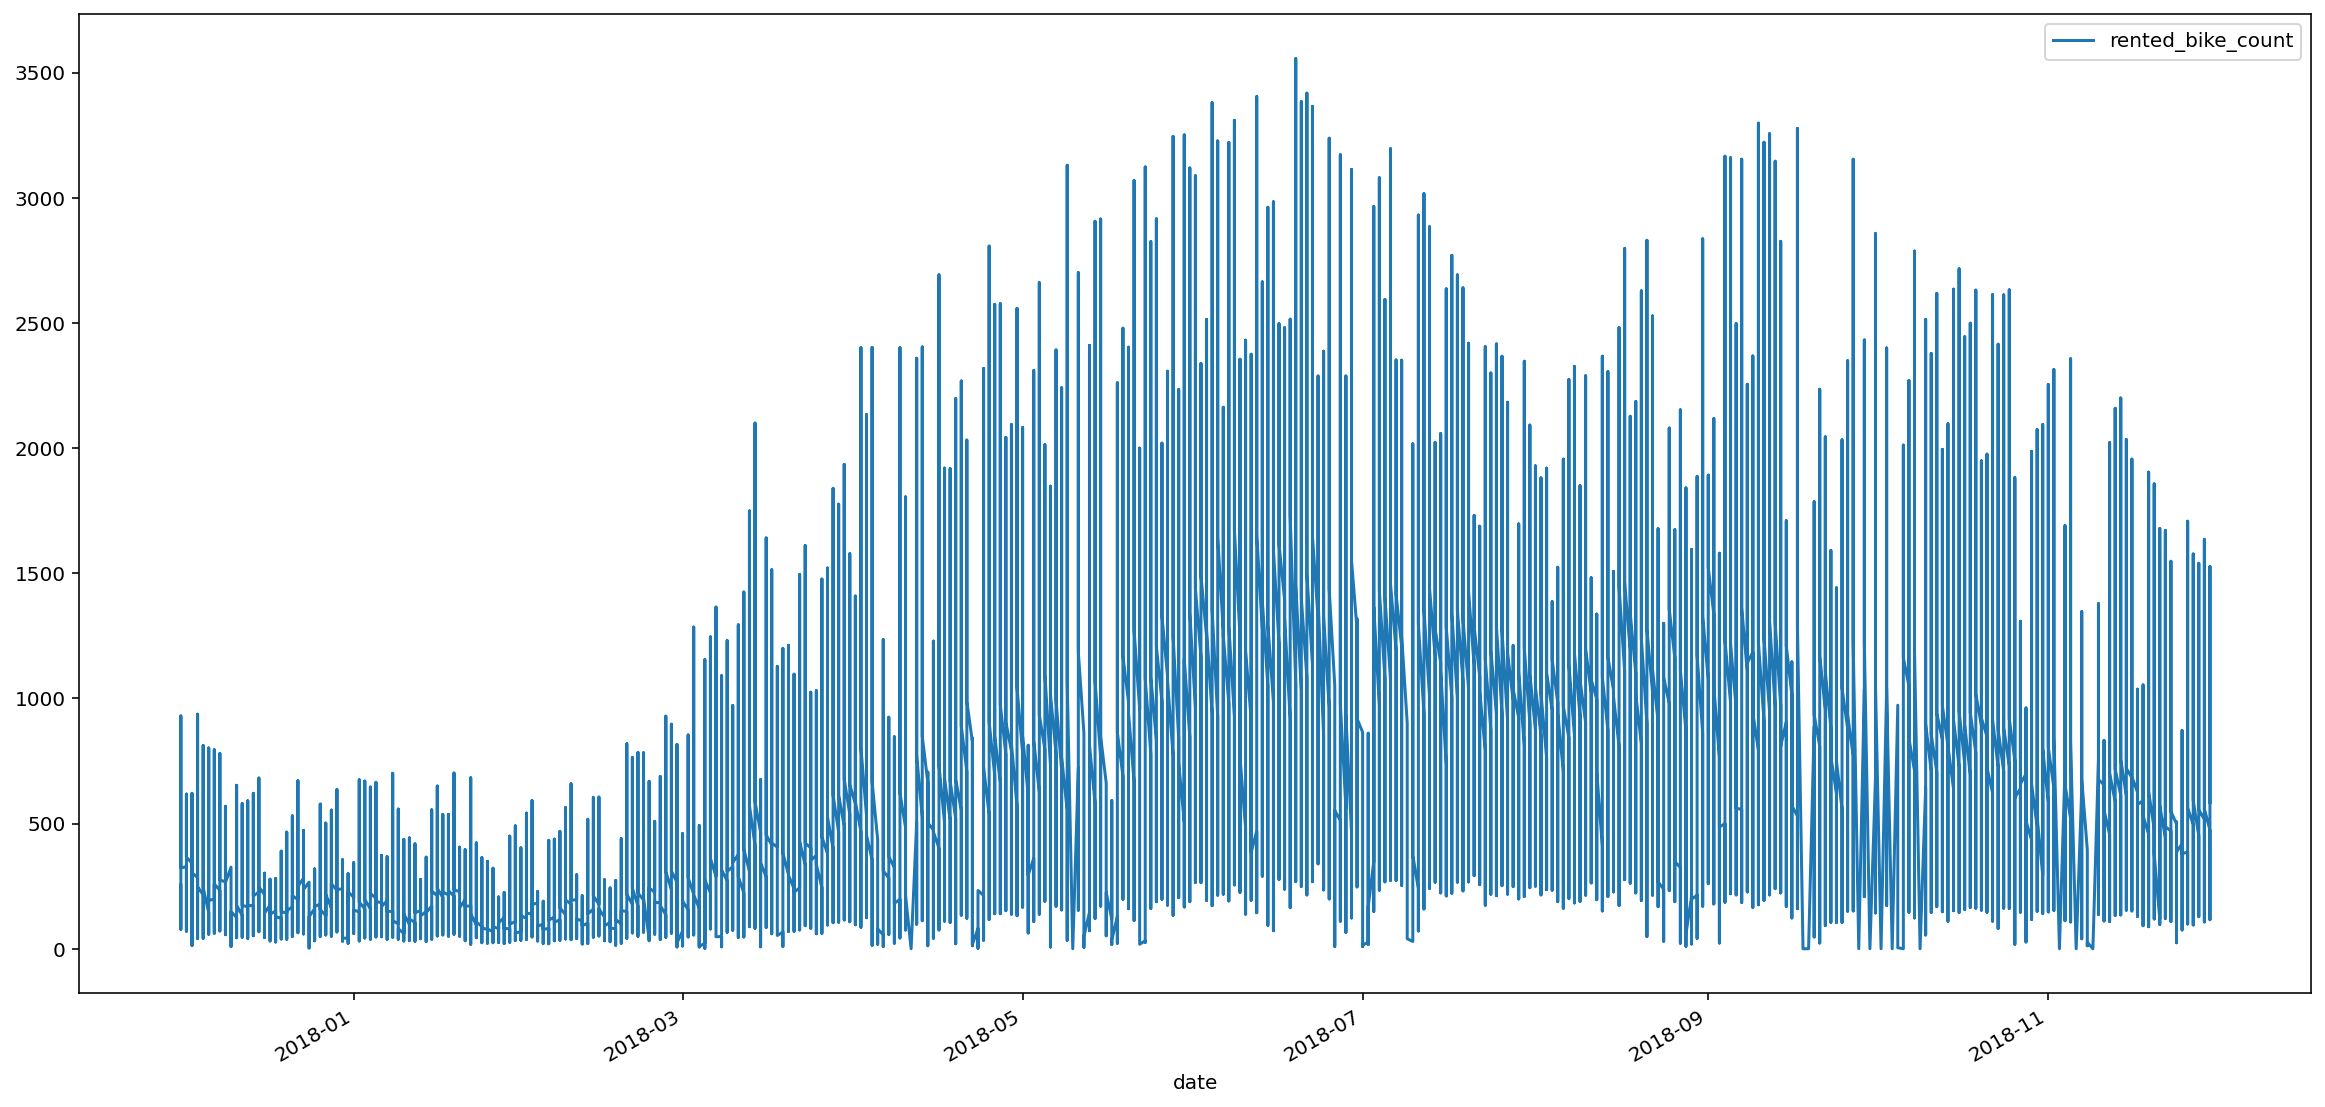

In [8]:
df.plot(x='date', y = 'rented_bike_count',figsize=(20, 10))

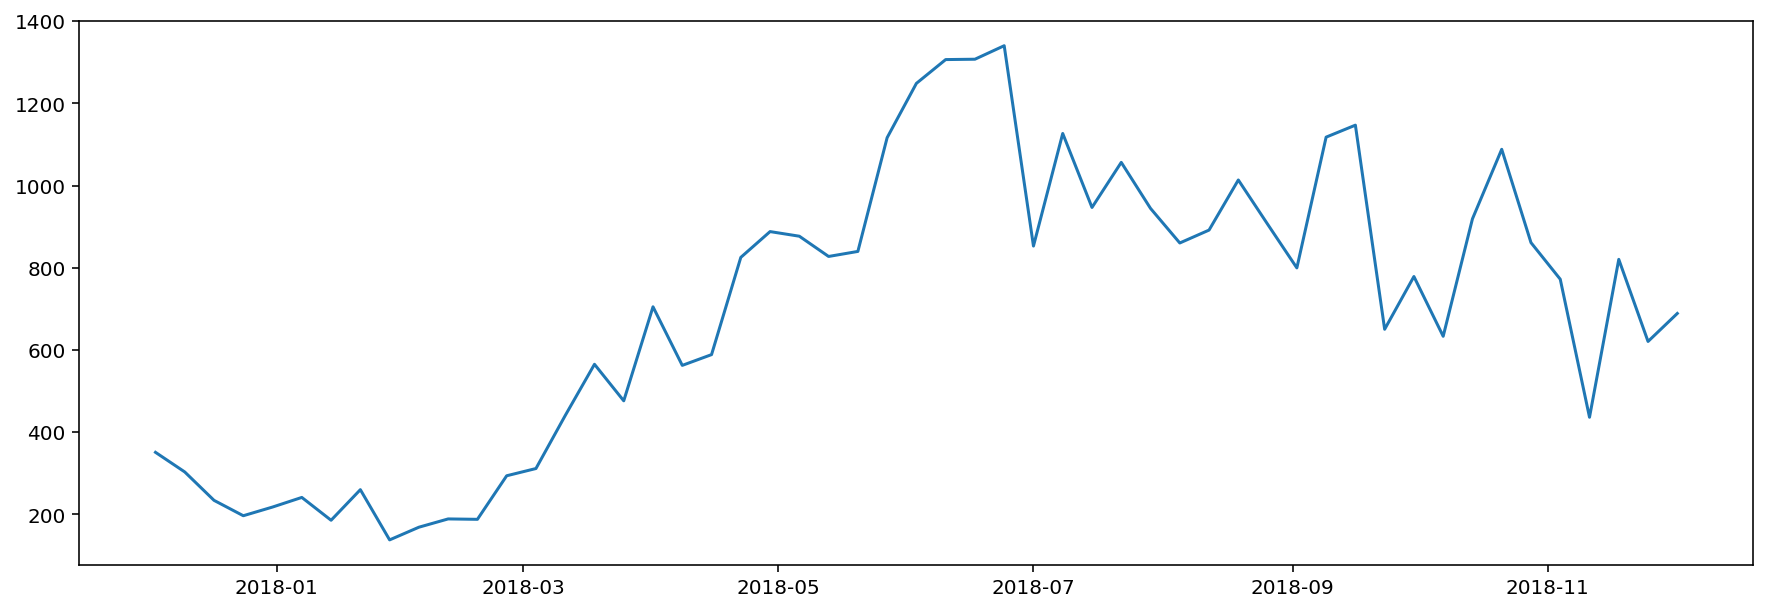

In [9]:
# Resample data weekly 
df_w = df.resample('W', on='date').mean()
# ploting Timeseries on weekly average rented bike counts
plt.figure(figsize=(15,5))
plt.plot(df_w.index, df_w.rented_bike_count)

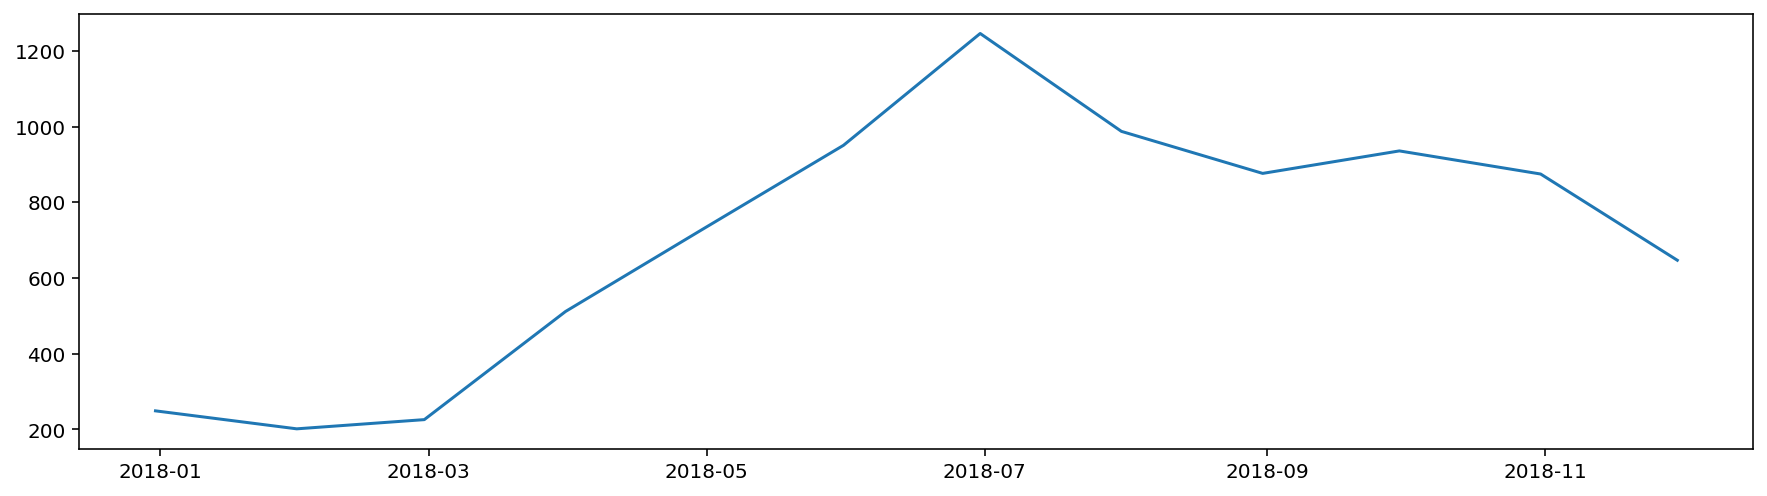

In [10]:
# Resample data Monthly 
df_m = df.resample('M', on='date').mean()
# ploting Timeseries on monthly average rented bike counts
plt.figure(figsize=(15,4))
plt.plot(df_m.index, df_m.rented_bike_count)

In [11]:
# from above plot, we need to create feature from date column to check impact of week day and month on counts on rented bikes.
df['week_day'] = df['date'].apply(lambda x: x.weekday())
df['month'] = df['date'].apply(lambda x: x.month)

In [12]:
df.skew().sort_values(ascending=True) # Snowfall and Rainfall are highly skewed

visibility           -0.701786
dew_point_temp       -0.367298
temp                 -0.198326
month                -0.010458
week_day             -0.003771
hour                  0.000000
hum                   0.059579
wind_speed            0.890955
rented_bike_count     1.153428
solar_radiation       1.504040
snowfall              8.440801
rainfall             14.533232
dtype: float64

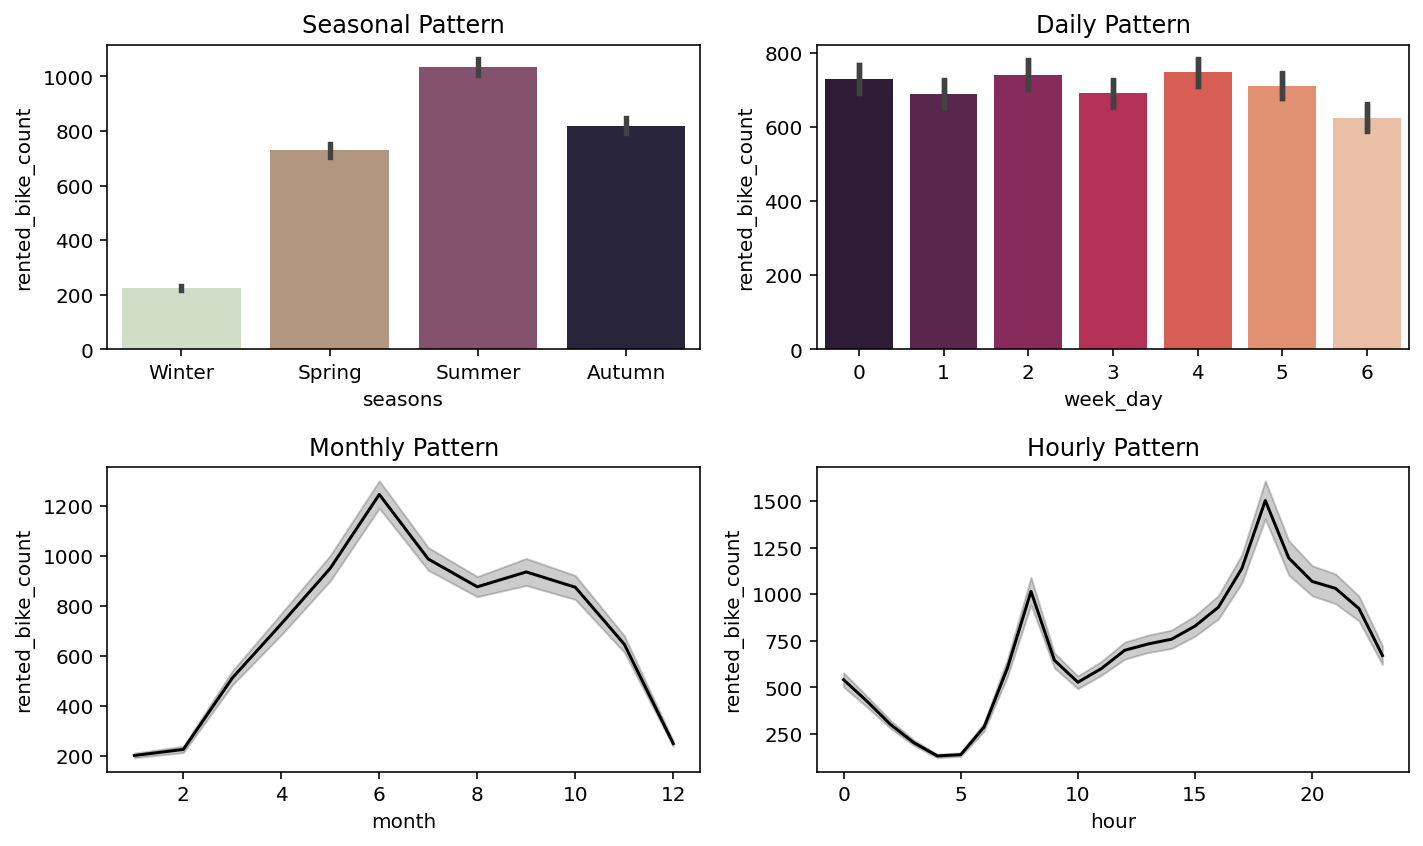

In [13]:
x = [['seasons', 'week_day'], ['month', 'hour']]
title = [['Seasonal Pattern', 'Daily Pattern'], ['Monthly Pattern', 'Hourly Pattern']]

f, ax = plt.subplots(2,2,figsize=(10,6))

for i in range(2):
    for j in range(2):
        if i==0:
            sns.barplot(data=df, x=x[i][j], y='rented_bike_count', ax=ax[i][j], palette='ch:s=-.3,r=.8')
            if j==1:
                sns.barplot(data=df, x=x[i][j], y='rented_bike_count', ax=ax[i][j], palette='rocket')
        else:
            sns.lineplot(data=df, x=x[i][j], y='rented_bike_count', ax=ax[i][j] , color = 'black')

        ax[i][j].set_title(title[i][j])
plt.tight_layout()

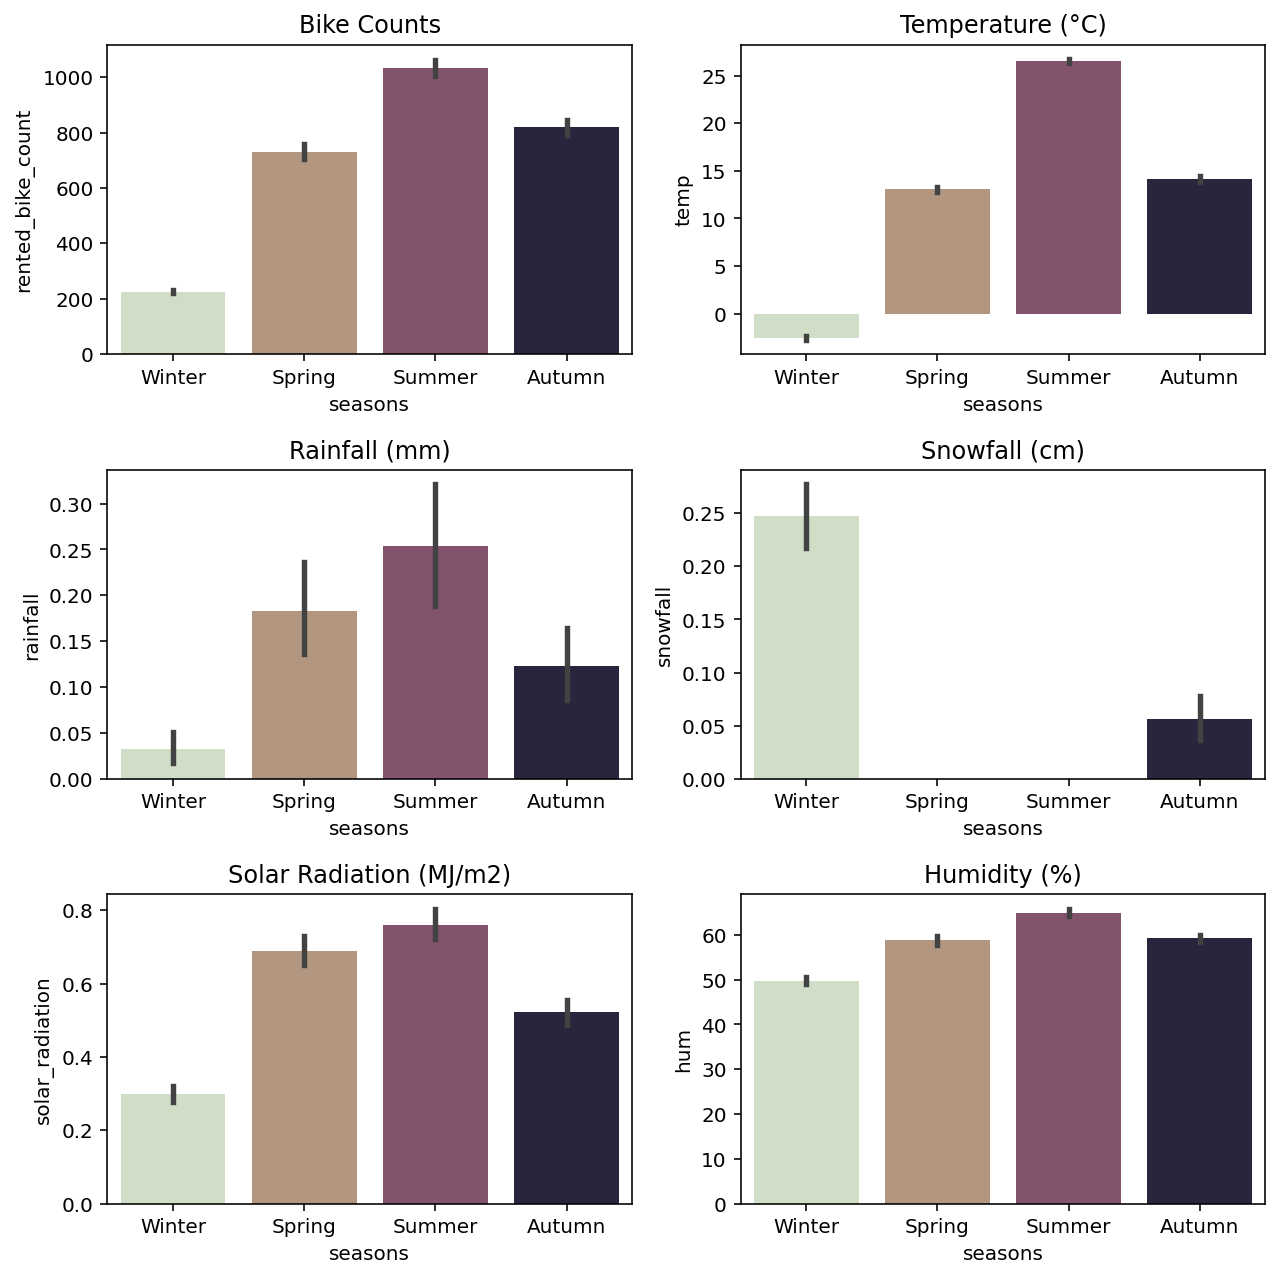

In [14]:
y = [['rented_bike_count', 'temp'], ['rainfall', 'snowfall'], ['solar_radiation', 'hum']]
title = [['Bike Counts', 'Temperature (°C)'], ['Rainfall (mm)', 'Snowfall (cm)'], 
         ['Solar Radiation (MJ/m2)', 'Humidity (%)']]

f, ax = plt.subplots(3,2,figsize=(9,9))

for i in range(3):
    for j in range(2):
        sns.barplot(data=df, x='seasons', y=y[i][j], ax=ax[i][j], palette='ch:s=-.3,r=.8')
        ax[i][j].set_title(title[i][j])

plt.tight_layout()        

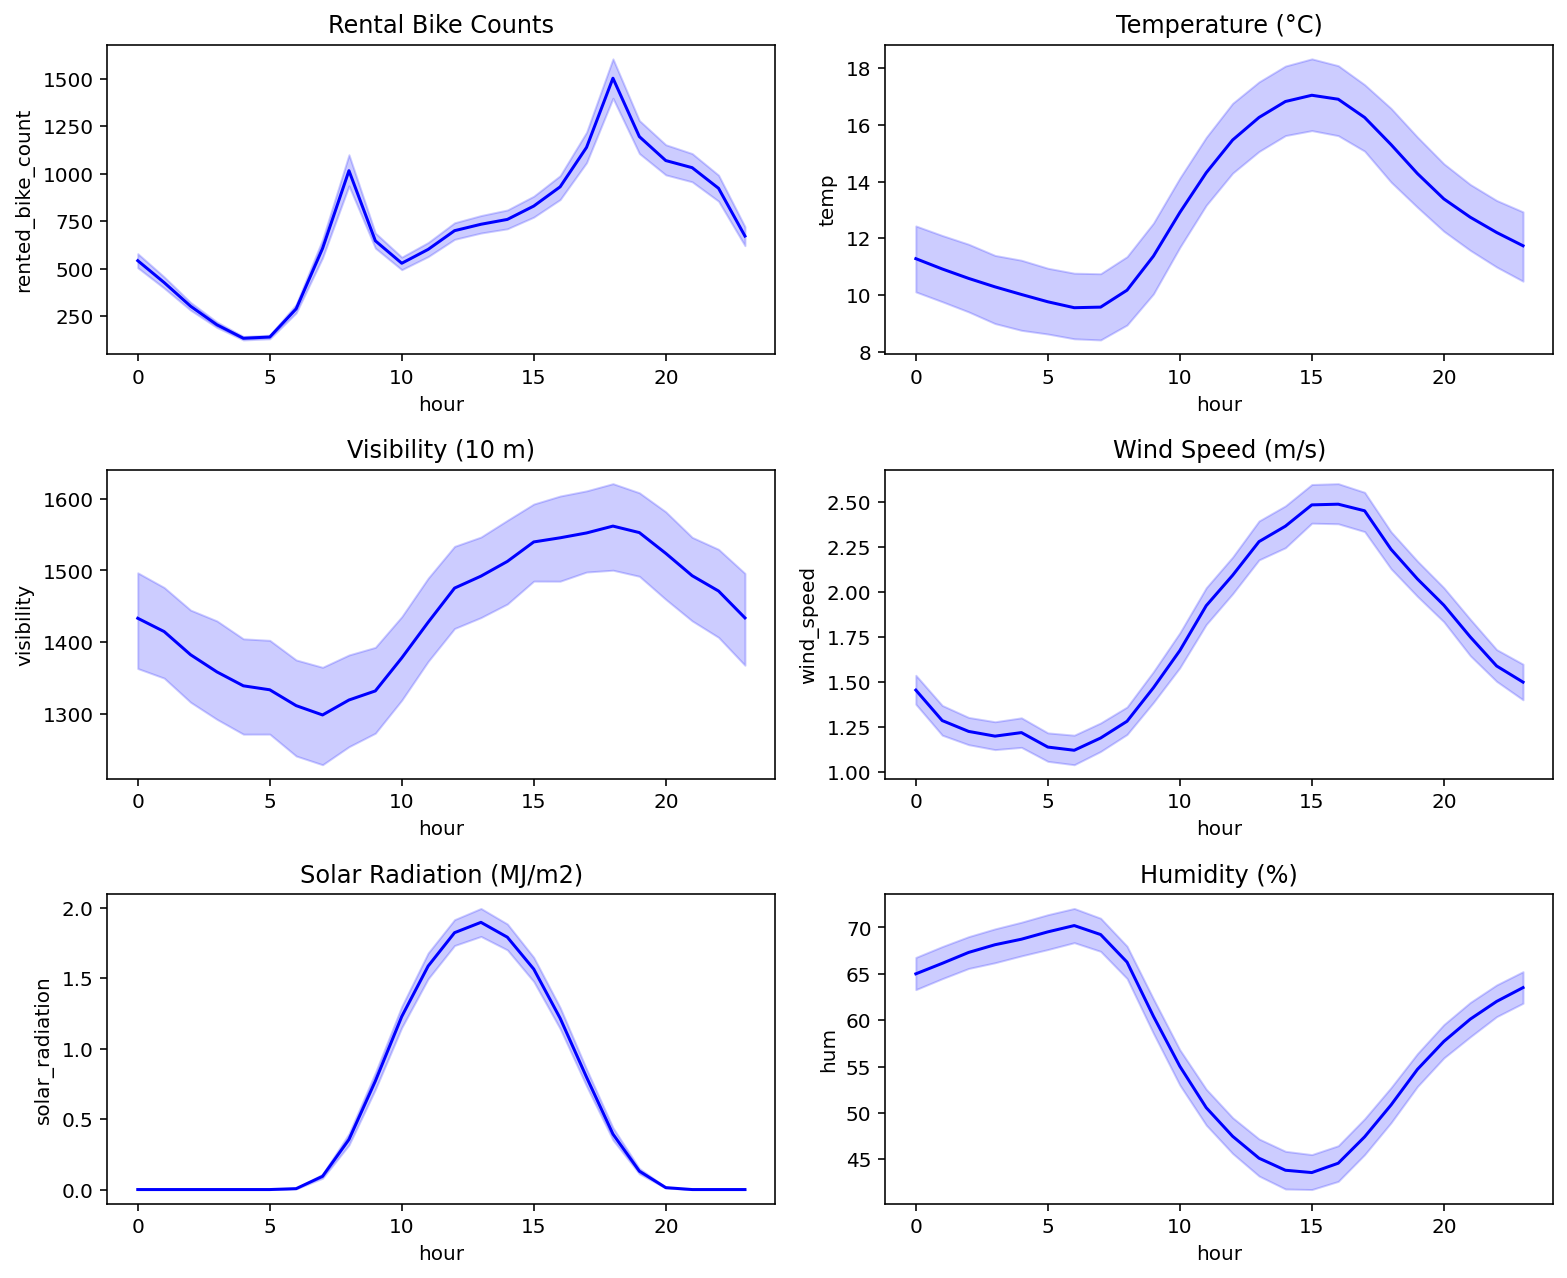

In [15]:
y = [['rented_bike_count', 'temp'], ['visibility', 'wind_speed'], ['solar_radiation', 'hum']]
title = [['Rental Bike Counts', 'Temperature (°C)'], ['Visibility (10 m)', 'Wind Speed (m/s)'], ['Solar Radiation (MJ/m2)', 'Humidity (%)']]

f, ax = plt.subplots(3,2,figsize=(11,9))

for i in range(3):
    for j in range(2):
        sns.lineplot(data=df, x='hour', y=y[i][j], ax=ax[i][j], color='b')
        ax[i][j].set_title(title[i][j])

plt.tight_layout()

In [16]:
pd.pivot_table(df, index=['functioning_day'], columns='seasons', values='rented_bike_count',
               aggfunc='sum', margins=True, margins_name='Total Rented Bikes')
# functioning_day : There is no rented bikes at Non Functional Hours

seasons,Autumn,Spring,Summer,Winter,Total Rented Bikes
functioning_day,,,,,
No,0.0,0.0,NaN,NaN,0
Yes,1790002.0,1611909.0,2283234.0,487169.0,6172314
Total Rented Bikes,1790002.0,1611909.0,2283234.0,487169.0,6172314


In [17]:
df[(df.holiday=='No Holiday') & (df.functioning_day=='No')].date.value_counts()
# On day 2018-10-06, bikes not rented only for 7 hours

2018-11-06    24
2018-11-09    24
2018-05-10    24
2018-09-28    24
2018-10-04    24
2018-10-02    24
2018-09-18    24
2018-04-11    24
2018-09-30    24
2018-11-03    24
2018-09-19    24
2018-10-06     7
Name: date, dtype: int64

# Exploratory data analysis

<ipython-input-18-b97c097c17fe>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))


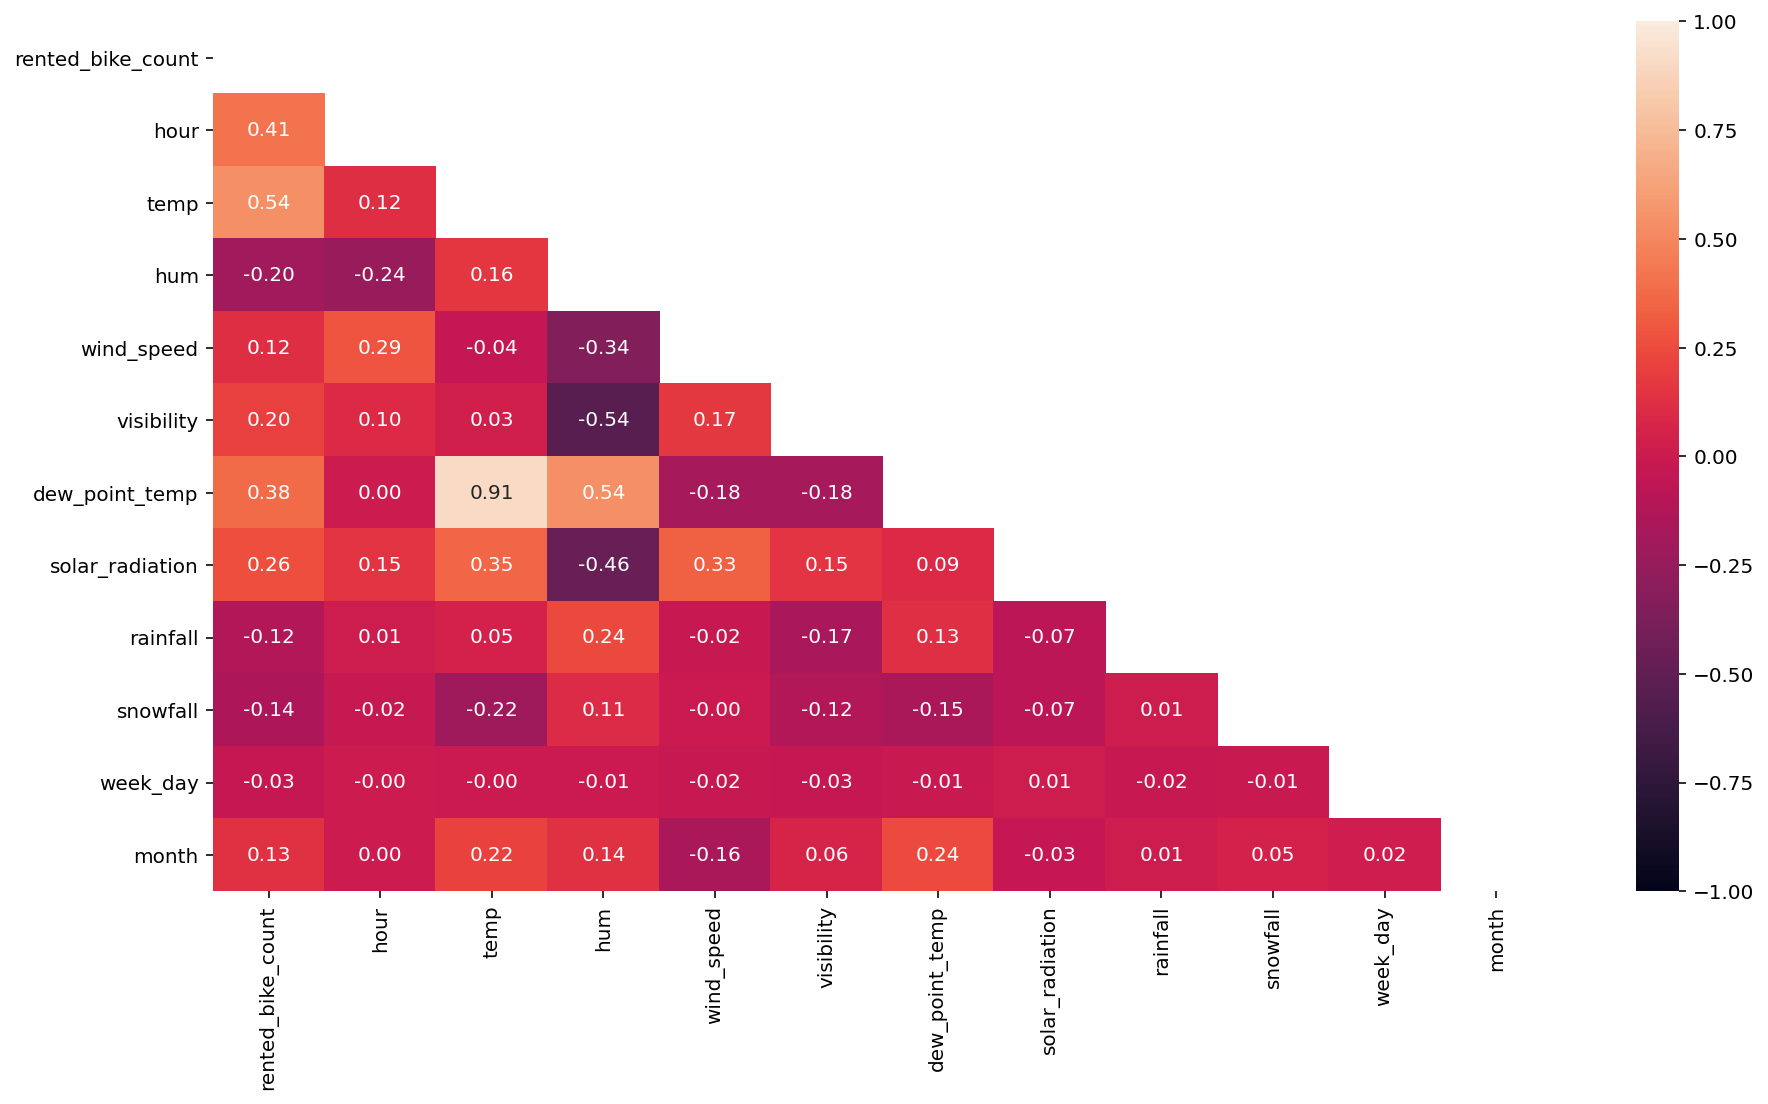

In [18]:
def correl(df):    
    plt.figure(figsize=(15,8))
    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, fmt='.2f')
correl(df)

# GradientBoostingRegressor

In [19]:
df['rented_bike_count_sqrt'] = df.rented_bike_count.apply(lambda x: np.sqrt(x))

<AxesSubplot:>

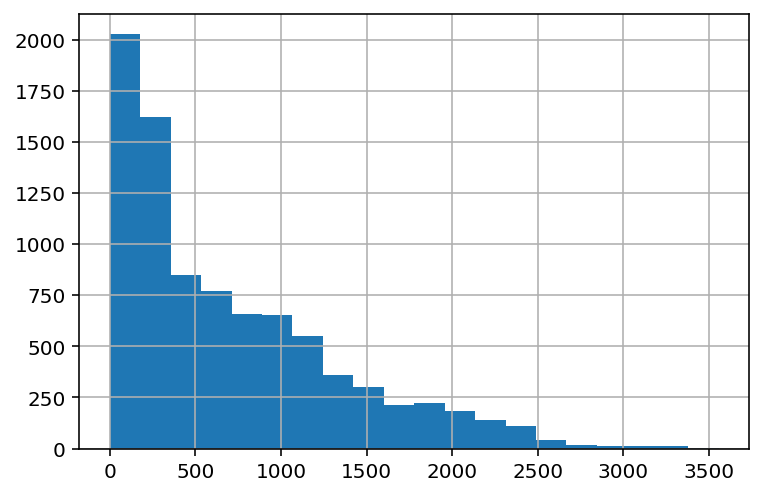

In [20]:
df['rented_bike_count'].hist(bins = 20)

<AxesSubplot:>

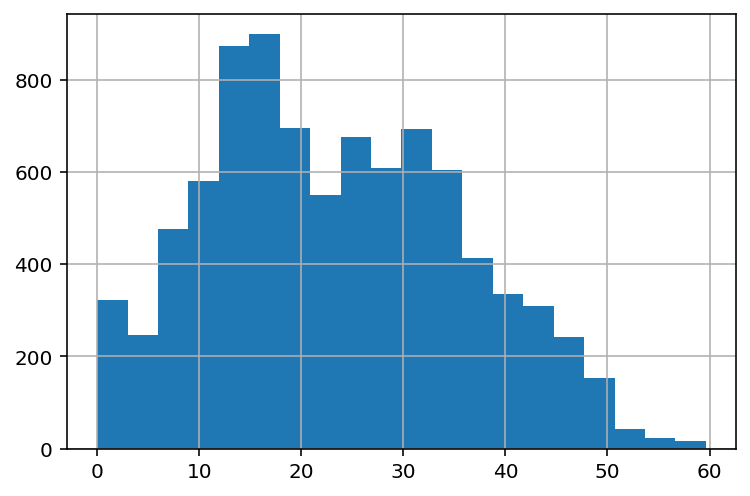

In [21]:
df['rented_bike_count_sqrt'].hist(bins = 20) # response variable transformed to get normal shape

In [22]:
X = df[['hour', 'temp', 'hum', 'wind_speed', 'visibility', 'dew_point_temp', 'solar_radiation', 'rainfall',
       'snowfall', 'seasons', 'holiday', 'functioning_day', 'week_day', 'month']]
y = df.rented_bike_count_sqrt
X = pd.get_dummies(X,columns = ['holiday', 'functioning_day', 'seasons'] , drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Pipeline with StandardScaler & baseline GradientBoostingRegressor
pipeline = make_pipeline(StandardScaler(), GradientBoostingRegressor())
# Cross-validation
cv = cross_val_score(pipeline, X_train, y_train, cv=10)
print('10-fold R2 scores:', [round(cv_score,4) for cv_score in cv])
print('Mean R2', round(np.mean(cv),4))

10-fold R2 scores: [0.8776, 0.8725, 0.9067, 0.8906, 0.9043, 0.8938, 0.8984, 0.885, 0.8935, 0.8982]
Mean R2 0.8921


In [23]:
# param = {'gradientboostingregressor__n_estimators': [25, 30, 50, 70,100],
#          'gradientboostingregressor__max_depth': [5, 10, 15, 20],
#          'gradientboostingregressor__subsample': [0.05, 0.07, 0.09]}
# grid = GridSearchCV(pipeline, param, verbose=1, cv=5, n_jobs=-1)
# grid.fit(X_train, y_train)
# print(grid.best_params_)
# print(grid.best_score_)

In [24]:
X = df[['hour', 'temp', 'hum', 'wind_speed', 'visibility', 'dew_point_temp', 'solar_radiation', 'rainfall',
       'snowfall', 'seasons', 'holiday', 'functioning_day', 'week_day', 'month']]
y = df.rented_bike_count_sqrt
X = pd.get_dummies(X,columns = ['holiday', 'functioning_day', 'seasons'] , drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Pipeline with StandardScaler & baseline XGBoost
pipeline = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=70, max_depth=9,
                                                    subsample=0.7))
# Cross-validation
cv = cross_val_score(pipeline, X_train, y_train, cv=10)
print('10-fold R2 scores:', [round(cv_score,4) for cv_score in cv])
print('Mean R2', round(np.mean(cv),4))

10-fold R2 scores: [0.9396, 0.9448, 0.9584, 0.9585, 0.9512, 0.9506, 0.9631, 0.9359, 0.9476, 0.9571]
Mean R2 0.9507


(0.0, 3500.0)

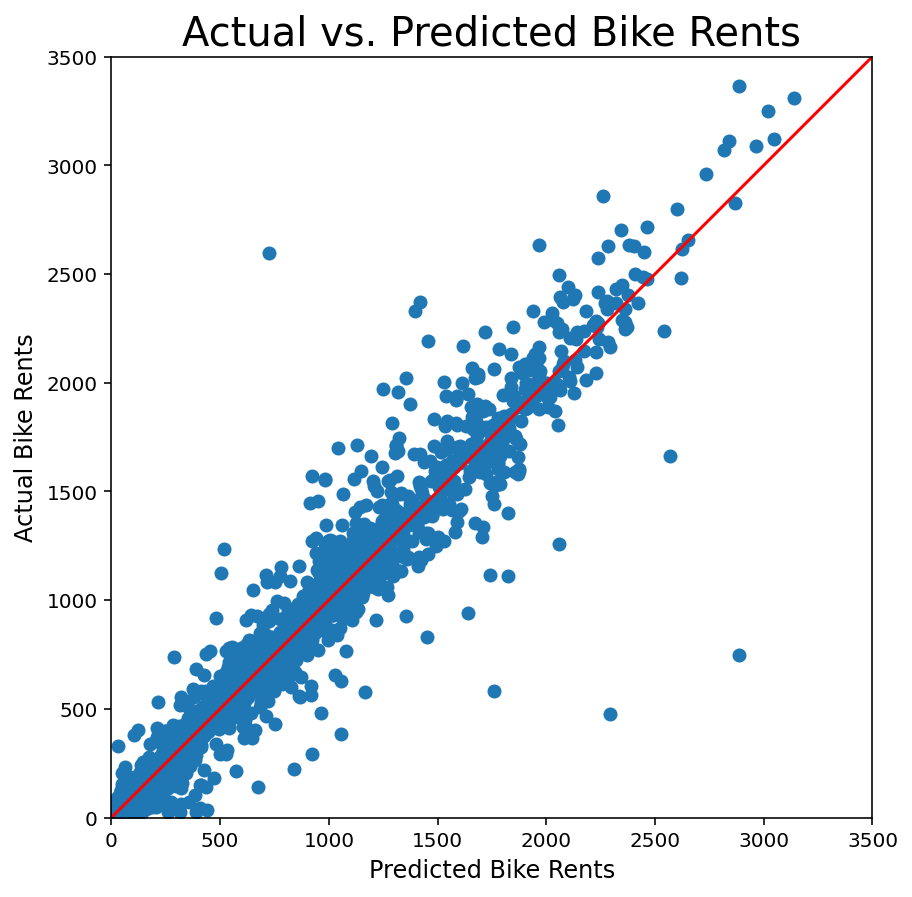

In [25]:
# Fit and predict
pipeline.fit(X_train, y_train)
y_pred_sqrt = pipeline.predict(X_test)
y_pred = [i**2 for i in y_pred_sqrt]
plt.figure(figsize=(7,7))

# 1:1 line
x = np.linspace(0,3500,10)
y = x

# Scatter plot predicted vs. actual
plt.scatter(y_pred, [i**2 for i in y_test])
plt.plot(x, y, c='r')
plt.gca().set_aspect('equal')
plt.xlabel('Predicted Bike Rents', size=12)
plt.ylabel('Actual Bike Rents', size=12)
plt.title('Actual vs. Predicted Bike Rents', size=20)
plt.xlim(0,3500)
plt.ylim(0,3500)

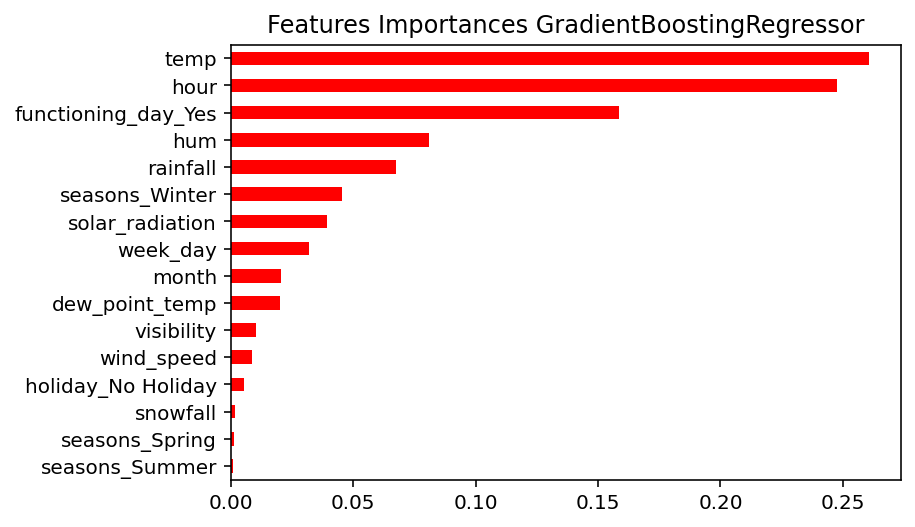

In [26]:
# Create a pd.Series of features importances
fimp = pipeline.steps[1][1].feature_importances_
importances = pd.Series(data=fimp,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='red')
plt.title('Features Importances GradientBoostingRegressor')
plt.show()

# XGBRegressor

In [27]:
X = df[['hour', 'temp', 'hum', 'wind_speed', 'visibility', 'dew_point_temp', 'solar_radiation', 'rainfall',
       'snowfall', 'seasons', 'holiday', 'functioning_day', 'week_day', 'month']]
y = df.rented_bike_count_sqrt
X = pd.get_dummies(X,columns = ['holiday', 'functioning_day', 'seasons'] , drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Pipeline with StandardScaler & baseline XGBRegressor
pipeline = make_pipeline(StandardScaler(), XGBRegressor())
# Cross-validation
cv = cross_val_score(pipeline, X_train, y_train, cv=10)
print('10-fold R2 scores:', [round(cv_score,4) for cv_score in cv])
print('Mean R2', round(np.mean(cv),4))

10-fold R2 scores: [0.9369, 0.944, 0.9552, 0.9535, 0.9495, 0.9461, 0.9608, 0.9358, 0.9446, 0.9504]
Mean R2 0.9477


In [28]:
# param = {'xgbregressor__n_estimators': [30, 50, 70],
#          'xgbregressor__max_depth': [5, 10, 20],
#          'xgbregressor__eta': [0.05, 0.08],
#          'xgbregressor__subsample': [0.5, 0.8],
#          'xgbregressor__reg_lambda': [0.7, 1, 1.2]}

# grid = GridSearchCV(pipe, param, verbose=1, cv=5, n_jobs=-1)

# grid.fit(X_train, y_train)

# print(grid.best_params_)
# print(grid.best_score_)

In [29]:
X = df[['hour', 'temp', 'hum', 'wind_speed', 'visibility', 'dew_point_temp', 'solar_radiation', 'rainfall',
       'snowfall', 'seasons', 'holiday', 'functioning_day', 'week_day', 'month']]
y = df.rented_bike_count_sqrt
X = pd.get_dummies(X,columns = ['holiday', 'functioning_day', 'seasons'] , drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Pipeline with StandardScaler & baseline XGBoost
pipeline = make_pipeline(StandardScaler(), XGBRegressor(n_estimators=70, max_depth=9, eta=0.08,
                                                    subsample=0.8, reg_lambda=1.3))
# Cross-validation
cv = cross_val_score(pipeline, X_train, y_train, cv=10)
print('10-fold R2 scores:', [round(cv_score,4) for cv_score in cv])
print('Mean R2', round(np.mean(cv),4))

10-fold R2 scores: [0.9446, 0.9434, 0.9612, 0.9563, 0.9509, 0.9539, 0.9661, 0.9435, 0.9469, 0.9547]
Mean R2 0.9521


(0.0, 3500.0)

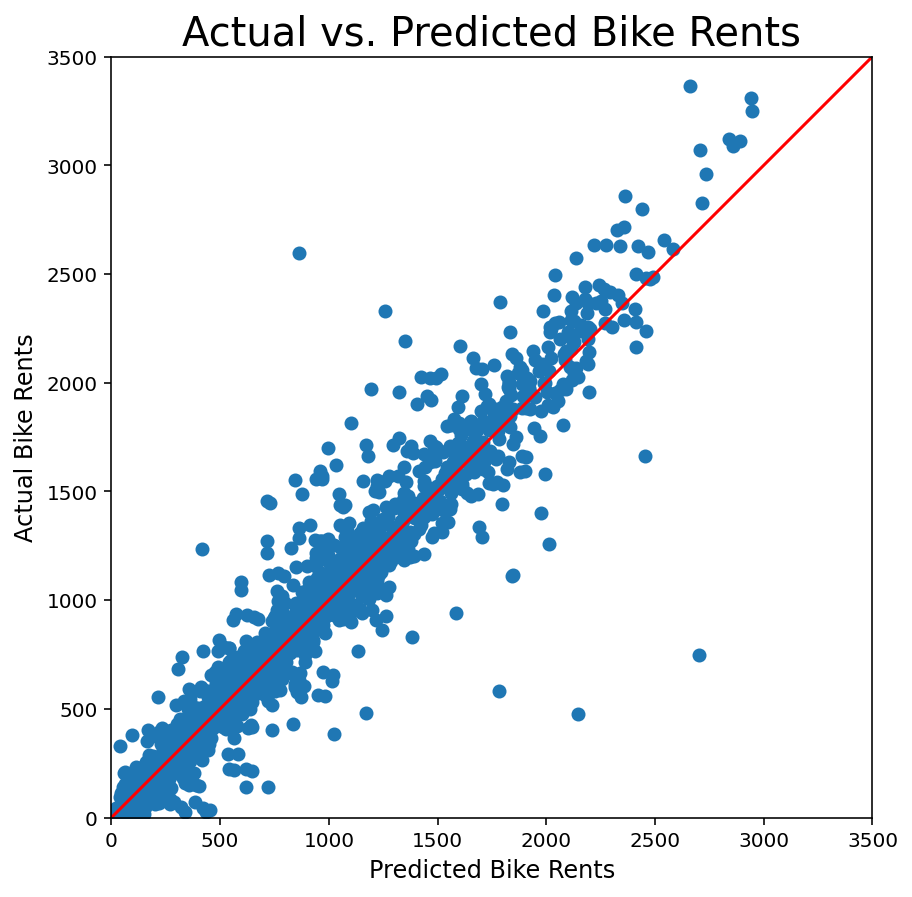

In [30]:
# Fit and predict
pipeline.fit(X_train, y_train)
y_pred_sqrt = pipeline.predict(X_test)
y_pred = [i**2 for i in y_pred_sqrt]
plt.figure(figsize=(7,7))

# 1:1 line
x = np.linspace(0,3500,10)
y = x

# Scatter plot predicted vs. actual
plt.scatter(y_pred, [i**2 for i in y_test])
plt.plot(x, y, c='r')
plt.gca().set_aspect('equal')
plt.xlabel('Predicted Bike Rents', size=12)
plt.ylabel('Actual Bike Rents', size=12)
plt.title('Actual vs. Predicted Bike Rents', size=20)
plt.xlim(0,3500)
plt.ylim(0,3500)

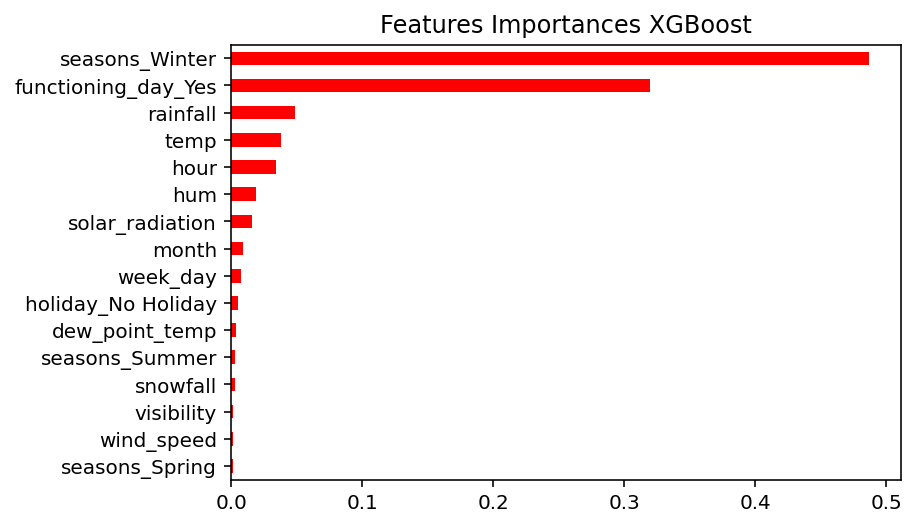

In [31]:
# Create a pd.Series of features importances
fimp = pipeline.steps[1][1].feature_importances_
importances = pd.Series(data=fimp,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='red')
plt.title('Features Importances XGBoost')
plt.show()

# RandomForestRegressor

In [32]:
X = df[['hour', 'temp', 'hum', 'wind_speed', 'visibility', 'dew_point_temp', 'solar_radiation', 'rainfall',
       'snowfall', 'seasons', 'holiday', 'functioning_day', 'week_day', 'month']]
y = df.rented_bike_count_sqrt
X = pd.get_dummies(X,columns = ['holiday', 'functioning_day', 'seasons'] , drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Pipeline with StandardScaler & baseline RandomForestRegressor
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor())
# Cross-validation
cv = cross_val_score(pipeline, X_train, y_train, cv=10)
print('10-fold R2 scores:', [round(cv_score,4) for cv_score in cv])
print('Mean R2', round(np.mean(cv),4))

10-fold R2 scores: [0.9305, 0.9388, 0.946, 0.9416, 0.943, 0.9343, 0.9537, 0.9238, 0.9322, 0.9433]
Mean R2 0.9387


In [33]:
# RF Regressor Baseline Mean R-Square is less than XGBRegressor but higher than GradientBoostingRegressor. 

(0.0, 3500.0)

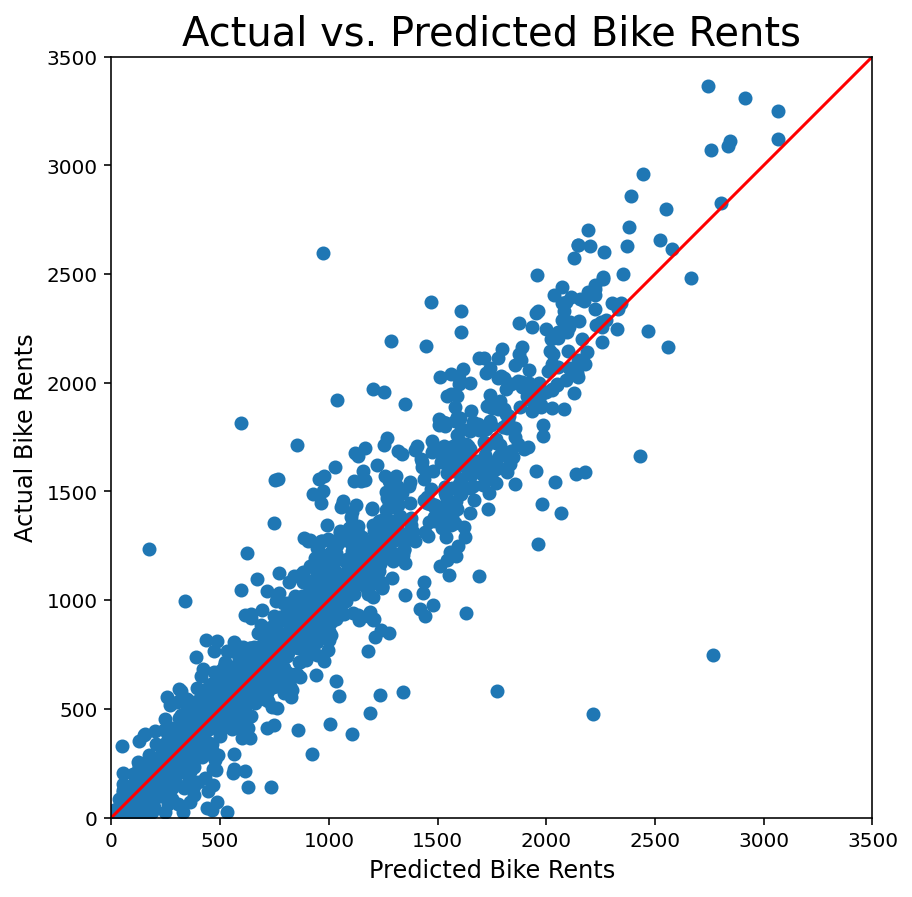

In [34]:
# Fit and predict
pipeline.fit(X_train, y_train)
y_pred_sqrt = pipeline.predict(X_test)
y_pred = [i**2 for i in y_pred_sqrt]
plt.figure(figsize=(7,7))

# 1:1 line
x = np.linspace(0,3500,10)
y = x

# Scatter plot predicted vs. actual
plt.scatter(y_pred, [i**2 for i in y_test])
plt.plot(x, y, c='r')
plt.gca().set_aspect('equal')
plt.xlabel('Predicted Bike Rents', size=12)
plt.ylabel('Actual Bike Rents', size=12)
plt.title('Actual vs. Predicted Bike Rents', size=20)
plt.xlim(0,3500)
plt.ylim(0,3500)

# Metric : R-Square
# Number of Bikes rental per hour prediction Using GradientBoostingRegressor : 95.08%
# Number of Bikes rental per hour prediction Using XGBoostRegressor : 95.21%